# Synthetic Data without interaction: recovery of relevant features

## Generate synthetic datasets

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from ignite.utils import manual_seed
from pyselect.synthesizer import make_regression_with_tensors, train_val_test_split

### Make regression dataset

In [2]:
n_features = 500
n_informative = 10

In [3]:
train_size = 4000
val_size = 1000
test_size = 1000

In [4]:
manual_seed(0)

In [5]:
X_mr, y_mr, coef_mr = make_regression_with_tensors(n_samples=6000, n_features=n_features, n_informative=n_informative)

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_mr, y_mr, train_size, val_size, test_size)


Datasets

In [7]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)

Dataloaders

In [8]:
train_loader = DataLoader(train, batch_size=200)
val_loader = DataLoader(val, batch_size=200)
test_loader = DataLoader(test, batch_size=100)

## Applying our method

In [9]:
import optuna
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.synthesizer import train_val_test_split

Loss function

In [10]:
def ridge_loss(y_pred, y_true, model, reg_param):
    weights = model.rff_net[2].weight.squeeze()
    loss = torch.mean(torch.square(y_pred-y_true)) + reg_param * weights.dot(weights)
    return loss

Score function for early stopping

In [11]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

Optuna callback to save best model

In [12]:
def best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])

Objective for optuna

In [13]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    out_features = 600
    model = RandomFourierFeaturesNet(n_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 300
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initialize optuna study

In [14]:
tpe_sampler = TPESampler(seed=0)

In [15]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-19 16:15:05,011] A new study created in memory with name: no-name-2f0af670-4d80-4aec-bd7b-b41f1b114814


In [16]:
n_epochs = 1050

In [17]:
study.optimize(objective, n_trials=40, callbacks=[best_model_callback])

Training - Epoch: 300 Loss: 1.00276
Validation - Epoch: 300 Loss: 1.07958
Learning rate: 0.0125
Training - Epoch: 600 Loss: 0.93900
Validation - Epoch: 600 Loss: 1.12320
Learning rate: 0.0063
Training - Epoch: 900 Loss: 0.91430
Validation - Epoch: 900 Loss: 1.14942
Learning rate: 0.0063


[I 2022-02-19 16:15:54,018] Trial 0 finished with value: 1.1624888916015625 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 0.0003766576841599299}. Best is trial 0 with value: 1.1624888916015625.


Training - Epoch: 300 Loss: 0.93681
Validation - Epoch: 300 Loss: 1.07632
Learning rate: 0.0161
Training - Epoch: 600 Loss: 0.85430
Validation - Epoch: 600 Loss: 1.13217
Learning rate: 0.0080
Training - Epoch: 900 Loss: 0.82183
Validation - Epoch: 900 Loss: 1.16765
Learning rate: 0.0080


[I 2022-02-19 16:16:38,976] Trial 1 finished with value: 1.1833250732421876 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 5.301709347576825e-05}. Best is trial 0 with value: 1.1624888916015625.


Training - Epoch: 300 Loss: 1.05859
Validation - Epoch: 300 Loss: 1.08321
Learning rate: 0.0070
Training - Epoch: 600 Loss: 0.96123
Validation - Epoch: 600 Loss: 1.05669
Learning rate: 0.0035
Training - Epoch: 900 Loss: 0.93330
Validation - Epoch: 900 Loss: 1.06491
Learning rate: 0.0035


[I 2022-02-19 16:17:22,734] Trial 2 finished with value: 1.0704176025390626 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 0.00016961746387290997}. Best is trial 2 with value: 1.0704176025390626.


Training - Epoch: 300 Loss: 1.21846
Validation - Epoch: 300 Loss: 1.24144
Learning rate: 0.0075
Training - Epoch: 600 Loss: 1.19022
Validation - Epoch: 600 Loss: 1.24074
Learning rate: 0.0038
Training - Epoch: 900 Loss: 1.18590
Validation - Epoch: 900 Loss: 1.24745
Learning rate: 0.0038


[I 2022-02-19 16:18:07,234] Trial 3 finished with value: 1.250845458984375 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 0.0028765041432547}. Best is trial 2 with value: 1.0704176025390626.


Training - Epoch: 300 Loss: 0.80624
Validation - Epoch: 300 Loss: 1.38515
Learning rate: 0.0846
Training - Epoch: 600 Loss: 0.67986
Validation - Epoch: 600 Loss: 1.46520
Learning rate: 0.0423
Training - Epoch: 900 Loss: 0.65697
Validation - Epoch: 900 Loss: 1.53523
Learning rate: 0.0423


[I 2022-02-19 16:18:52,831] Trial 4 finished with value: 1.56838623046875 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 8.264328927007728e-06}. Best is trial 2 with value: 1.0704176025390626.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:19:07,288] Trial 5 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.84306


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:19:22,067] Trial 6 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.28749


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:19:35,790] Trial 7 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.88573


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:19:49,866] Trial 8 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 2.06865


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:20:03,102] Trial 9 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.13757


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:20:15,984] Trial 10 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.17659


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:20:29,552] Trial 11 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.11336


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:20:42,540] Trial 12 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.36679


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:20:56,880] Trial 13 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.97637
Training - Epoch: 300 Loss: 1.00775
Validation - Epoch: 300 Loss: 1.05775
Learning rate: 0.0094
Training - Epoch: 600 Loss: 0.91699
Validation - Epoch: 600 Loss: 1.06281
Learning rate: 0.0047
Training - Epoch: 900 Loss: 0.88505
Validation - Epoch: 900 Loss: 1.08614
Learning rate: 0.0047


[I 2022-02-19 16:21:41,526] Trial 14 finished with value: 1.0990145263671875 and parameters: {'learning_rate': 0.009432065169882079, 'reg_param': 7.856776519976887e-06}. Best is trial 2 with value: 1.0704176025390626.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:21:53,980] Trial 15 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.06916


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:22:06,341] Trial 16 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.33829


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:22:19,406] Trial 17 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.86193


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:22:31,886] Trial 18 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.09152


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:22:44,187] Trial 19 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.83318
Training - Epoch: 300 Loss: 1.00462
Validation - Epoch: 300 Loss: 1.07877
Learning rate: 0.0093
Training - Epoch: 600 Loss: 0.91868
Validation - Epoch: 600 Loss: 1.09919
Learning rate: 0.0047
Training - Epoch: 900 Loss: 0.88896
Validation - Epoch: 900 Loss: 1.12270
Learning rate: 0.0047


[I 2022-02-19 16:23:27,853] Trial 20 finished with value: 1.1348927001953124 and parameters: {'learning_rate': 0.009309200987535229, 'reg_param': 1.8071771194171694e-05}. Best is trial 2 with value: 1.0704176025390626.


Training - Epoch: 300 Loss: 1.03637
Validation - Epoch: 300 Loss: 1.07069
Learning rate: 0.0081
Training - Epoch: 600 Loss: 0.93408
Validation - Epoch: 600 Loss: 1.06346
Learning rate: 0.0040
Training - Epoch: 900 Loss: 0.89988
Validation - Epoch: 900 Loss: 1.07792
Learning rate: 0.0040


[I 2022-02-19 16:24:12,753] Trial 21 finished with value: 1.0863524169921874 and parameters: {'learning_rate': 0.008066261699405322, 'reg_param': 2.2810592711394918e-05}. Best is trial 2 with value: 1.0704176025390626.


Training - Epoch: 300 Loss: 0.97530
Validation - Epoch: 300 Loss: 1.03630
Learning rate: 0.0105
Training - Epoch: 600 Loss: 0.89879
Validation - Epoch: 600 Loss: 1.05457
Learning rate: 0.0053
Training - Epoch: 900 Loss: 0.86901
Validation - Epoch: 900 Loss: 1.07226
Learning rate: 0.0053


[I 2022-02-19 16:24:58,986] Trial 22 finished with value: 1.0818607177734374 and parameters: {'learning_rate': 0.010525829900125686, 'reg_param': 3.0868632943851904e-06}. Best is trial 2 with value: 1.0704176025390626.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:25:11,937] Trial 23 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.91504


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:25:24,460] Trial 24 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.19999


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:25:36,716] Trial 25 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.56097


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:25:48,923] Trial 26 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.05628


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:26:01,975] Trial 27 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.04769


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:26:16,126] Trial 28 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.51106
Training - Epoch: 300 Loss: 0.97321
Validation - Epoch: 300 Loss: 1.06481
Learning rate: 0.0109
Training - Epoch: 600 Loss: 0.89018
Validation - Epoch: 600 Loss: 1.09660
Learning rate: 0.0054
Training - Epoch: 900 Loss: 0.85683
Validation - Epoch: 900 Loss: 1.12228
Learning rate: 0.0054


[I 2022-02-19 16:27:03,643] Trial 29 finished with value: 1.135904296875 and parameters: {'learning_rate': 0.010872605747034653, 'reg_param': 1.3637890552915028e-06}. Best is trial 2 with value: 1.0704176025390626.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:27:15,809] Trial 30 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.86746
Training - Epoch: 300 Loss: 1.02072
Validation - Epoch: 300 Loss: 1.06746
Learning rate: 0.0086
Training - Epoch: 600 Loss: 0.92620
Validation - Epoch: 600 Loss: 1.06839
Learning rate: 0.0043
Training - Epoch: 900 Loss: 0.89364
Validation - Epoch: 900 Loss: 1.08427
Learning rate: 0.0043


[I 2022-02-19 16:28:01,330] Trial 31 finished with value: 1.092926513671875 and parameters: {'learning_rate': 0.008556491591112407, 'reg_param': 5.604619911769437e-06}. Best is trial 2 with value: 1.0704176025390626.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:28:14,089] Trial 32 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.02992


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:28:27,175] Trial 33 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.92337
Training - Epoch: 300 Loss: 0.95582
Validation - Epoch: 300 Loss: 1.03854
Learning rate: 0.0137
Training - Epoch: 600 Loss: 0.87013
Validation - Epoch: 600 Loss: 1.08200
Learning rate: 0.0069
Training - Epoch: 900 Loss: 0.83565
Validation - Epoch: 900 Loss: 1.11214
Learning rate: 0.0069


[I 2022-02-19 16:29:14,077] Trial 34 finished with value: 1.1264295654296874 and parameters: {'learning_rate': 0.013720237355800875, 'reg_param': 2.2351284516792487e-05}. Best is trial 2 with value: 1.0704176025390626.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:29:27,762] Trial 35 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.30321


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:29:40,181] Trial 36 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.02526
Training - Epoch: 300 Loss: 0.94758
Validation - Epoch: 300 Loss: 1.06511
Learning rate: 0.0149
Training - Epoch: 600 Loss: 0.86615
Validation - Epoch: 600 Loss: 1.12345
Learning rate: 0.0074
Training - Epoch: 900 Loss: 0.83316
Validation - Epoch: 900 Loss: 1.15820
Learning rate: 0.0074


[I 2022-02-19 16:30:26,733] Trial 37 finished with value: 1.1746016845703124 and parameters: {'learning_rate': 0.014887403700581359, 'reg_param': 4.636209054158863e-05}. Best is trial 2 with value: 1.0704176025390626.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-19 16:30:38,861] Trial 38 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.06320
Training - Epoch: 300 Loss: 0.98461
Validation - Epoch: 300 Loss: 1.05587
Learning rate: 0.0106
Training - Epoch: 600 Loss: 0.90247
Validation - Epoch: 600 Loss: 1.07900
Learning rate: 0.0053
Training - Epoch: 900 Loss: 0.87064
Validation - Epoch: 900 Loss: 1.10213
Learning rate: 0.0053


[I 2022-02-19 16:31:24,444] Trial 39 finished with value: 1.113901123046875 and parameters: {'learning_rate': 0.010590732282183123, 'reg_param': 7.796022116703618e-07}. Best is trial 2 with value: 1.0704176025390626.


Get best model

In [18]:
best_model = study.user_attrs['best_model']

In [19]:
torch.save(best_model.state_dict(), '../models/make-regression.pth')

Replicate best model on different test datasets

In [20]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test, _ = make_regression_with_tensors(n_samples=test_size, n_features=n_features,
                                                  n_informative=n_informative)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [21]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-19 16:31:24,480] A new study created in memory with name: no-name-45a2e63f-8171-45de-8eff-439092147b2b


In [22]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-19 16:31:24,499] Trial 0 finished with value: 4.690570244517184 and parameters: {}. Best is trial 0 with value: 4.690570244517184.
[I 2022-02-19 16:31:24,513] Trial 1 finished with value: 4.807435037587611 and parameters: {}. Best is trial 0 with value: 4.690570244517184.
[I 2022-02-19 16:31:24,526] Trial 2 finished with value: 2.4859633287470273 and parameters: {}. Best is trial 2 with value: 2.4859633287470273.
[I 2022-02-19 16:31:24,538] Trial 3 finished with value: 4.040104012236257 and parameters: {}. Best is trial 2 with value: 2.4859633287470273.
[I 2022-02-19 16:31:24,552] Trial 4 finished with value: 4.405612099215046 and parameters: {}. Best is trial 2 with value: 2.4859633287470273.
[I 2022-02-19 16:31:24,566] Trial 5 finished with value: 3.1597060286520326 and parameters: {}. Best is trial 2 with value: 2.4859633287470273.
[I 2022-02-19 16:31:24,579] Trial 6 finished with value: 3.5397722108474015 and parameters: {}. Best is trial 2 with value: 2.4859633287470273

In [23]:
replication.trials_dataframe()['value'].mean()

3.745635329566808

In [24]:
replication.trials_dataframe()['value'].std()

0.6751394816455555

### Visualizing

#### Bands

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
bands = best_model.rff_net[0].bandwidths.to('cpu').detach().numpy()

In [27]:
inf_features = (np.abs(coef_mr) >= 1e-3).ravel()

In [28]:
inf_bands = bands[inf_features]
noninf_bands = bands[~inf_features]

In [29]:
lim = np.abs(bands).max()
bins = np.linspace(-lim * 1.1, lim * 1.1, 40)

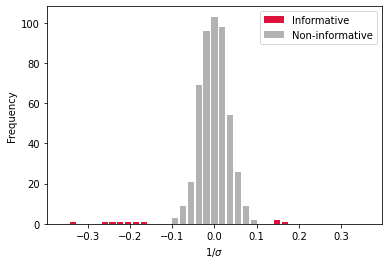

In [36]:
fig = plt.figure()
plt.hist(inf_bands, bins=bins, rwidth=0.8, color="crimson", label="Informative")
plt.hist(
    noninf_bands,
    bins=bins,
    rwidth=0.8,
    color="black",
    alpha=0.3,
    label="Non-informative",
)
plt.xlabel(r"1/$\sigma$")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.show()

In [37]:
index = np.array(list(range(0, n_features)))
inf_index = index[inf_features]
noninf_index = index[~inf_features]

In [38]:
inf_index

array([ 15,  90, 153, 159, 254, 283, 316, 445, 461, 489])

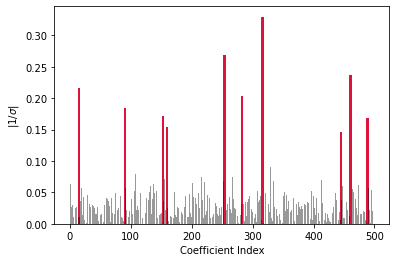

In [39]:
fig = plt.figure()
plt.bar(
    inf_index,
    np.abs(bands[inf_features]),
    color="crimson",
    width=4,
    label="Informative",
)
plt.bar(
    noninf_index,
    np.abs(bands[~inf_features]),
    color="black",
    alpha=0.4,
    label="Non-informative",
)
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
plt.show()

In [40]:
model_linear_weights = best_model.rff_net[2].weight.to('cpu').detach().numpy().ravel()

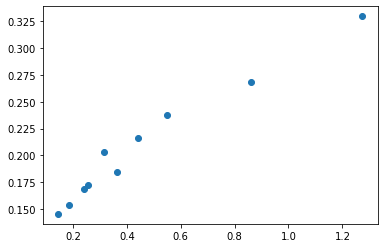

In [41]:
plt.plot(np.abs(coef_mr[inf_features]), np.abs(bands[inf_features]), 'o')
plt.show()